In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from scipy.special import kn
from scipy import optimize
from utils import *

## Initialize data

In [2]:
n_ens = 5
n_ops = 5
ensembles = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004']
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
colors = ['r', 'g', 'b', 'c', 'y']
L_cfgs = [24, 24, 32, 32, 32]
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each file differently

# Lattice spacing and physical constants from PDG. Pairs are (value, error), and everything should be in GeV.
ainv_24I = [1.784, 0.005]
ainv_32I = [2.382, 0.008]

# # PDG values
# mpi_0 = (0.13957039, 1.8e-7)        # (value, error) in GeV
# fpi_0 = (0.1302, 1.2e-3)
# David's values for testing-- use PDG values after testing
mpi_0   = [ 0.13957018, 0.00000035 ]
fpi_0   = [ 0.13041, np.sqrt(0.00003**2 + 0.00020**2) ]

In [3]:
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each file differently
mpi_0_ens, fpi_0_ens = Superboot(n_ens), Superboot(n_ens)
mpi_0_ens.gen_fake_ensemble(mpi_0[0], mpi_0[1])
fpi_0_ens.gen_fake_ensemble(fpi_0[0], fpi_0[1])

# generate lattice ensemble for each size and map between ensemble <--> size
ainv_24I_ens = Superboot(n_ens)
ainv_32I_ens = Superboot(n_ens)
ainv_24I_ens.gen_fake_ensemble(ainv_24I[0], ainv_24I[1])
ainv_32I_ens.gen_fake_ensemble(ainv_32I[0], ainv_32I[1])
ainv_ens = [ainv_24I_ens, ainv_24I_ens, ainv_32I_ens, ainv_32I_ens, ainv_32I_ens]

hbarc = 0.197326   # conversion from fm to GeV, in units GeV * fm
asq_24I_ens = ainv_24I_ens ** (-2)
asq_32I_ens = ainv_32I_ens ** (-2)
asq_24I_fms = asq_24I_ens.scale(hbarc ** 2)
asq_32I_fms = asq_32I_ens.scale(hbarc ** 2)
asq_ens = [asq_24I_fms, asq_24I_fms, asq_32I_fms, asq_32I_fms, asq_32I_fms]

#### Use my data (for actual final analysis)

In [4]:
# Generate fake ensembles. 
mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
for ens_idx, config in enumerate(ensembles):
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
    f = h5py.File(path, 'r')
    a4_mat_elems_raw = f['fits'][()]
    for i in range(n_ops):
        # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
        mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
        a4_mat_elems_ens = Superboot(n_ens)
        a4_mat_elems_ens.populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
        a4_mat_elems_ens = a4_mat_elems_ens.scale(mult_factor)
        mat_elems_ens[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
    f.close()
    # read in two point data
    ampi_ens = Superboot(n_ens)
    afpi_ens = Superboot(n_ens)
    # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
    path2pt = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/twopt_out.h5'
    twopt_data = h5py.File(path2pt, 'r')
    ampi_boot = twopt_data['ampi']
    afpi_boot = twopt_data['afpi']
    ampi_ens.populate_ensemble(ampi_boot, ens_idx)
    afpi_ens.populate_ensemble(afpi_boot, ens_idx)

    mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
    fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
    eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
    eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Use David's data

In [ ]:
# David's data
ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
# enter this data in format [ens_idx, op_idx] with pairs (mu, sigma)
a4_matelem_david = np.array([
    [[-0.04648, 0.00025], [-0.07996, 0.00057], [0.002768, 0.000013], [-0.14345, 0.00080], [0.01951, 0.00014]], 
    [[-0.03903, 0.00026], [-0.06667, 0.00065], [0.0013953, 0.0000095], [-0.12229, 0.00081], [0.01633, 0.00016]], 
    [[-0.01476, 0.00011], [-0.02323, 0.00024], [0.0006677, 0.0000043], [-0.04591, 0.00036], [0.005778, 0.000061]], 
    [[-0.013052, 0.000094], [-0.02059, 0.00020], [0.0004511, 0.0000028], [-0.04087, 0.00030], [0.005132, 0.000050]], 
    [[-0.011753, 0.000091], [-0.01847, 0.00021], [0.0002745, 0.0000022], [-0.03705, 0.00029], [0.004608, 0.000053]]
])

# Generate fake ensembles. 
mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
for ens_idx, config in enumerate(ensembles):
    for i in range(n_ops):
        mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
        a4_mat_elems_ens = Superboot(n_ens)
        a4_mat_elems_ens.gen_fake_ensemble_axis(a4_matelem_david[ens_idx, i, 0], a4_matelem_david[ens_idx, i, 1], ens_idx)
        a4_mat_elems_ens = a4_mat_elems_ens.scale(mult_factor)
        mat_elems_ens[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
    ampi_ens = Superboot(n_ens)
    afpi_ens = Superboot(n_ens)
    # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
    # This reads in david's values for ampi, afpi and should be used for testing.
    ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
    afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)

    mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
    fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
    eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
    eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Use David's 2pt function data with my matrix elements

In [ ]:
# Generate fake ensembles. 
ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
for ens_idx, config in enumerate(ensembles):
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
    f = h5py.File(path, 'r')
    a4_mat_elems_raw = f['fits'][()]
    for i in range(n_ops):
        # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
        mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
        a4_mat_elems_ens = Superboot(n_ens)
        a4_mat_elems_ens.populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
        a4_mat_elems_ens = a4_mat_elems_ens.scale(mult_factor)
        mat_elems_ens[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
    f.close()
    ampi_ens = Superboot(n_ens)
    afpi_ens = Superboot(n_ens)
    # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
    # This reads in david's values for ampi, afpi and should be used for testing.
    ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
    afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)

    mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
    fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
    eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
    eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Propagate error and print data

In [5]:
# generate information in tables 2 and 3-- get the mean and STD of bootstrapped ensembles
print('Running statistics with physical units')
mat_elem_mu = [[mat_elems_ens[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)]
mat_elem_sigma = [[mat_elems_ens[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)]
mpi_mu = [mpi_ens[i].compute_mean() for i in range(n_ens)]
mpi_sigma = [mpi_ens[i].compute_std() for i in range(n_ens)]
fpi_mu = [fpi_ens[i].compute_mean() for i in range(n_ens)]
fpi_sigma = [fpi_ens[i].compute_std() for i in range(n_ens)]
eps_mu = [eps_sq_ens[i].compute_mean() for i in range(n_ens)]
eps_sigma = [eps_sq_ens[i].compute_std() for i in range(n_ens)]
eps_phys_mu = [eps_sq_phys_ens[i].compute_mean() for i in range(n_ens)]
eps_phys_sigma = [eps_sq_phys_ens[i].compute_std() for i in range(n_ens)]
ainv_ens_mu = [ainv_ens[i].compute_mean() for i in range(n_ens)]
ainv_ens_sigma = [ainv_ens[i].compute_std() for i in range(n_ens)]
asq_ens_mu = [asq_ens[i].compute_mean() for i in range(n_ens)]
asq_ens_sigma = [asq_ens[i].compute_std() for i in range(n_ens)]

for ens_idx in range(n_ens):
    print(ensembles[ens_idx])
    print('a^-1 = ' + str(ainv_ens_mu[ens_idx]) + ' \pm ' + str(ainv_ens_sigma[ens_idx]) + ' GeV')
    print('a^2 = ' + str(asq_ens_mu[ens_idx]) + ' \pm ' + str(asq_ens_sigma[ens_idx]) + ' fm^2')
    print('m_pi: ' + str(mpi_mu[ens_idx]) + ' \pm ' + str(mpi_sigma[ens_idx]) + ' GeV')
    print('f_pi: ' + str(fpi_mu[ens_idx]) + ' \pm ' + str(fpi_sigma[ens_idx]) + ' GeV')
    print('epsilon_pi_sq: ' + str(eps_mu[ens_idx]) + ' \pm ' + str(eps_sigma[ens_idx]))
    print('epsilon_pi_phys_sq (to plot at): ' + str(eps_phys_mu[ens_idx]) + ' \pm ' + str(eps_phys_sigma[ens_idx]))
    for op_idx in range(n_ops):
        print(labels[op_idx]+': '+str(mat_elem_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
    print('\n')

Running statistics with physical units
24I/ml_0p01
a^-1 = 1.78411981993478 \pm 0.004782718774455845 GeV
a^2 = 0.012232703160252099 \pm 6.560909526837971e-05 fm^2
m_pi: 0.43068504944284536 \pm 0.0015199647306380101 GeV
f_pi: 0.16440693467041673 \pm 0.0006890027656072396 GeV
epsilon_pi_sq: 0.08691464952718174 \pm 0.0007237873786428644
epsilon_pi_phys_sq (to plot at): 0.13812619459023168 \pm 0.0007116509702149741
O1: -0.029388761832661838 \pm 0.0003864576901379262 (GeV)^4
O2: -0.10125344202213361 \pm 0.001455203565467493 (GeV)^4
O3: 0.0035042343828550065 \pm 4.355682612377701e-05 (GeV)^4
O1p: -0.09081412990659629 \pm 0.0012002947719437227 (GeV)^4
O2p: 0.024706950436744864 \pm 0.00035511931985637634 (GeV)^4


24I/ml_0p005
a^-1 = 1.78411981993478 \pm 0.004782718774455845 GeV
a^2 = 0.012232703160252099 \pm 6.560909526837971e-05 fm^2
m_pi: 0.3408679352125306 \pm 0.0014151015057073215 GeV
f_pi: 0.1518336441291749 \pm 0.0006110762581801334 GeV
epsilon_pi_sq: 0.06383364794212466 \pm 0.0005547929

<IPython.core.display.Javascript object>


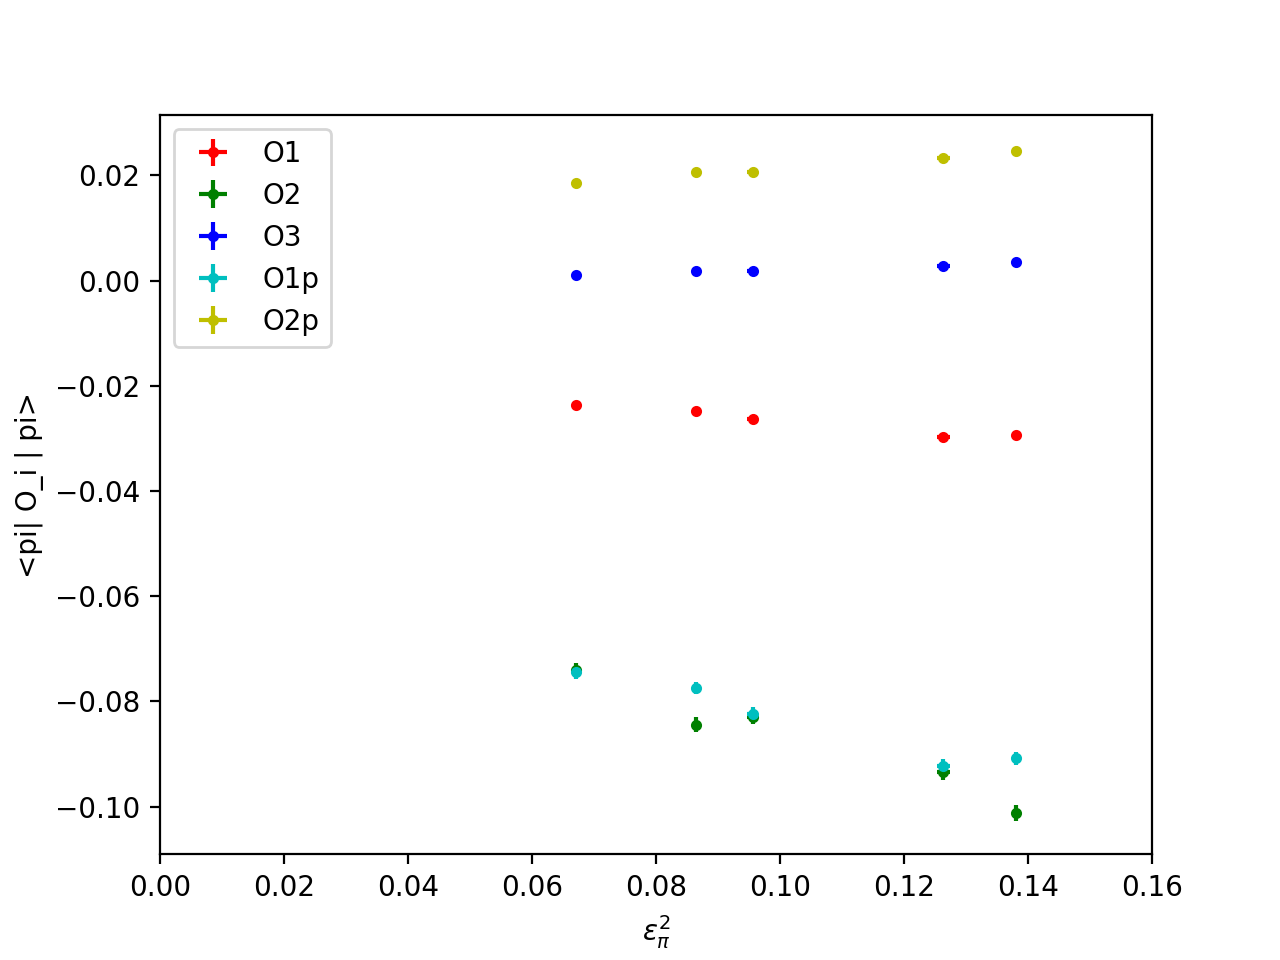

In [6]:
# Plot data points. This shouldn't match up with David's graph, that graph is plotting these points after subtracting the fit off
plt.figure()
for i in range(n_ops):
    plt.errorbar(eps_phys_mu, [mat_elem_mu[j][i] for j in range(n_ens)], xerr = eps_phys_sigma, yerr = [mat_elem_sigma[j][i] for j in range(n_ens)], fmt = '.', c = colors[i], label = labels[i])
plt.xlabel('$\epsilon_\pi^2$')
plt.ylabel('<pi| O_i | pi>')
plt.legend()
plt.xlim((0, 0.16))
# plt.ylim((-0.08, 0.02))
plt.show()

## Perform the fit

In [7]:
def f0(m, L, ainv):
    f0 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f0 += -2 * kn(0, (m / ainv) * L * n)
    return f0
def f1(m, L, ainv):
    f1 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f1 += 4 * kn(1, (m / ainv) * L * n) / ((m / ainv) * L * n)
    return f1
# for O1, O2, O1p, O2p, fv = -f0 + 2*f1, for O3 fv = f0 + 2*f1
def get_fv_fn(op_idx):
    if op_idx == 2:    # for O3
        return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, L, ainv)
    return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, L, ainv)
# this mirrors David's code, but it should be a bug: inputs L = 32 for the f1 piece regardless of ensemble.
#     if op_idx == 2:    # for O3
#         return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, 32, ainv)
#     return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, 32, ainv)

In [8]:
# Define functional fit forms for the operators (these agree with David's functions)
def O1(a1, b1, c1, m, f, a_sq, fv):    # a_lat should be in GeV^-1, 
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m ** 2) / Lam_sq
    return b1*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c1 + fv) + a1 * a_sq)
def O2(a2, b2, c2, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return b2*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c2 + fv) + a2 * a_sq)
def O3(a3, b3, c3, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return e_sq * b3*Lam_sq**2/(16*np.pi**2) * (1 - e_sq*(3*np.log(e_sq) + 1 - c3 + fv) + a3 * a_sq)
def get_chi2(O_fn):
    def chi2(x, m, f, a_sq, fv, O_val, dO):    # x should be (alpha, beta, c), the fit params to get
        val = 0.0
        for j in range(n_ens):
            val += (O_fn(x[0], x[1], x[2], m[j], f[j], a_sq[j], fv[j]) - O_val[j]) ** 2 / (dO[j] ** 2)
        return val
    return chi2
O_list = [O1, O2, O3, O1, O2]
chi2_list = [get_chi2(Oi) for Oi in O_list]

#### Fit to mean

In [9]:
# construct guesses for solution
# TODO: get guesses by fitting to mean values. Right now I just copied david's values over
n_fit_params = 3
guesses0 = np.array([
    [-1.3, -1.7, -0.8], 
    [10.3, -5.0, -1.1], 
    [51.4, 0.6, 1.7], 
    [-1.5, -5.5, -1.1], 
    [7.7, 1.3, -1.1]
], dtype = np.float64)
guesses1 = np.zeros((n_ops, n_fit_params), dtype = np.float64)
# fit mean values to get guesses1
for op_idx in range(n_ops):
    print(op_idx)
    fv = get_fv_fn(op_idx)
    fv_list = np.array([fv(mpi_mu[ens_idx], L_cfgs[ens_idx], ainv_ens_mu[ens_idx]) for ens_idx in range(n_ens)])
    O_elems = np.array([mat_elem_mu[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    O_elems_sigma = np.array([mat_elem_sigma[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    out = optimize.minimize(chi2_list[op_idx], guesses0[op_idx], args = (mpi_mu, fpi_mu, asq_ens_mu, \
            fv_list, O_elems, O_elems_sigma), method = 'Powell', options = {'maxiter':10000, 'ftol':1.0e-08})
    guesses1[op_idx, :] = out['x'][:]

0
1
2
3
4


In [10]:
# the difference in fits to mean each time I run them is due to uncertainty in the lattice spacing, since I haven't 
# seeded the random number generator for the fake ensembles
print('Results of fits to mean:')
print('α | β | c')
for i in range(n_ens):
    print(labels[i])
    print(guesses1[i])

Results of fits to mean:
α | β | c
O1
[-7.16650898 -1.72766092 -0.17137882]
O2
[ 3.19326516 -4.9742111  -0.27528603]
O3
[43.60165803  0.63308699  1.39549587]
O1p
[-7.2709804  -5.5523971  -0.41884921]
O2p
[ 0.65288339  1.27018767 -0.2876572 ]


#### Fit to full data

In [11]:
alpha = [Superboot(n_ens) for i in range(n_ops)]
beta = [Superboot(n_ens) for i in range(n_ops)]
c = [Superboot(n_ens) for i in range(n_ops)]
# store the matrix elements after subtraction here. phys == actual results subtracted back to the physical point, 
# subtracted == extrapolated results to physical decay constant and lattice spacing at different pion masses. 
# plot eps_sq_subtracted vs mat_elems_subtracted.
mat_elems_phys = [Superboot(n_ens) for j in range(n_ops)]    # extrapolate to the physical pion mass
mat_elems_subtracted = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
chi2_boots = [Superboot(n_ens) for i in range(n_ops)]
chi2_ndof_boots = [Superboot(n_ens) for i in range(n_ops)]
m_range = np.linspace(0.0, 0.5, 101)    # range of m's to plot chiral extrapolation band at
band_data = [[Superboot(n_ens) for j in range(n_ops)] for i in range(len(m_range) - 1)]
for op_idx in range(n_ops):
    print('Operator ' + labels[op_idx])
    fv = get_fv_fn(op_idx)
    guess = guesses1[op_idx]
    O_sigma = np.array([mat_elem_sigma[i][op_idx] for i in range(n_ens)])    # uncertainty doesn't change per boot idx
    for ens_idx in range(n_ens):
        for b_idx in range(n_samples[ens_idx]):
            print('Ensemble ' + str(ens_idx) + ', boot ' + str(b_idx))
            m_boot = np.array([mpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            f_boot = np.array([fpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            ainv_boot = np.array([ainv_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            asq_boot = np.array([asq_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            fv_boot = np.array([fv(m_boot[i], L_cfgs[i], ainv_boot[i]) for i in range(n_ens)])
            O_boot = np.array([mat_elems_ens[i][op_idx].boots[ens_idx, b_idx] for i in range(n_ens)])
            out = optimize.minimize(chi2_list[op_idx], guess, args = (m_boot, f_boot, asq_boot, fv_boot, O_boot, \
                                        O_sigma), method = 'Powell', options = {'maxiter' : 10000, 'ftol' : 1.0e-08})
            alphab, betab, cb = out['x']
            print(alphab, betab, cb)
            alpha[op_idx].boots[ens_idx, b_idx] = alphab
            beta[op_idx].boots[ens_idx, b_idx] = betab
            c[op_idx].boots[ens_idx, b_idx] = cb
            chi2_boots[op_idx].boots[ens_idx, b_idx] = out.fun
            chi2_ndof_boots[op_idx].boots[ens_idx, b_idx] = out.fun / (n_ens - 3.0)   # 5 - 3, for 3 fit params
            # subtract off extrapolation @ phys point to get extrapolated matrix element
            mat_elems_phys[op_idx].boots[ens_idx, b_idx] = O_list[op_idx](alphab, betab, cb, mpi_0_ens.boots[ens_idx, b_idx], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            
            # subtract off artifacts and extrapolate everything but the pion mass away-- these are the plotted points
            for i in range(n_ens):
                mat_elems_subtracted[i][op_idx].boots[ens_idx, b_idx] = O_boot[i] \
                    - O_list[op_idx](alphab, betab, cb, m_boot[i], f_boot[i], asq_boot[i], fv_boot[i]) \
                    + O_list[op_idx](alphab, betab, cb, m_boot[i], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            for m in range(len(m_range) - 1):    # extrapolate to value m for the pion mass
                band_data[m][op_idx].boots[ens_idx, b_idx] = \
                    O_list[op_idx](alphab, betab, cb, m_range[m + 1], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)

Operator O1
Ensemble 0, boot 0
-7.598474915480662 -1.7463100290486688 -0.23746440426369778
Ensemble 0, boot 1
-6.883336017209511 -1.714435125105807 -0.1210808578491158
Ensemble 0, boot 2
-7.106907112646011 -1.7243809465052793 -0.15895485544389806
Ensemble 0, boot 3
-6.984119003594087 -1.7192260852267325 -0.13621973317777156
Ensemble 0, boot 4
-7.2587580117610395 -1.732495290699806 -0.18975696137317255
Ensemble 0, boot 5
-7.986304239840944 -1.766267340840608 -0.3105586024921287
Ensemble 0, boot 6
-8.407798854280221 -1.786344382788826 -0.3786475103119255
Ensemble 0, boot 7
-6.958506188723451 -1.7177986060206827 -0.1326022872865325
Ensemble 0, boot 8
-7.213610190462403 -1.7303012596494467 -0.180686517113922
Ensemble 0, boot 9
-7.691438102572339 -1.7532445018679677 -0.2634676958557222
Ensemble 0, boot 10
-7.354004823142064 -1.7392824466047196 -0.2131831402628213
Ensemble 0, boot 11
-7.179120992138916 -1.7280297932212405 -0.17583607156613879
Ensemble 0, boot 12
-7.154495214027341 -1.7263478

-6.7943926947677316 -1.7297390561577293 -0.23936719694286135
Ensemble 2, boot 5
-6.782283046107094 -1.7299016553730684 -0.2423009410565398
Ensemble 2, boot 6
-7.420589502516214 -1.7255308644880354 -0.12291768811618334
Ensemble 2, boot 7
-7.55090847887457 -1.7263357142797466 -0.10848554248496438
Ensemble 2, boot 8
-9.551770857437841 -1.712481941982609 0.2817137183089275
Ensemble 2, boot 9
-5.464427211232431 -1.735070480750505 -0.4760694725267107
Ensemble 2, boot 10
-9.479365928567116 -1.7137282383151813 0.25571633804637
Ensemble 2, boot 11
-6.95749348223876 -1.7286065401917114 -0.20737160094128568
Ensemble 2, boot 12
-7.638232435739677 -1.7256818982837754 -0.08610493002420656
Ensemble 2, boot 13
-7.020059483067718 -1.7296833778728382 -0.20551896576946857
Ensemble 2, boot 14
-8.425623966489702 -1.719802756092065 0.06442963299491355
Ensemble 2, boot 15
-6.769860513584252 -1.7293432252278902 -0.24051449287310578
Ensemble 2, boot 16
-6.64798400512211 -1.7306296364624323 -0.2658832853949311


-7.138256948986347 -1.7245604607811529 -0.15990510050565773
Ensemble 4, boot 9
-7.185011126313288 -1.7303652229341442 -0.1824282293643391
Ensemble 4, boot 10
-7.236792386782058 -1.7438678478594665 -0.23278275602735002
Ensemble 4, boot 11
-7.292276458969512 -1.7517277434068437 -0.2622461740801692
Ensemble 4, boot 12
-7.129726836906277 -1.7231449363957176 -0.15420827763156114
Ensemble 4, boot 13
-6.97497875591999 -1.6883066562339366 -0.013661691884459282
Ensemble 4, boot 14
-7.0353227193145855 -1.7012011309869421 -0.06764853030228672
Ensemble 4, boot 15
-7.124739418372132 -1.7210170699937781 -0.14590118429989732
Ensemble 4, boot 16
-7.494357700040037 -1.7866120903854077 -0.3887136546225056
Ensemble 4, boot 17
-7.381295045656911 -1.7715582189265455 -0.3348366126834545
Ensemble 4, boot 18
-7.22611233337644 -1.7328946286195677 -0.19132014220091798
Ensemble 4, boot 19
-7.252755616965828 -1.7476033068728543 -0.24663270265960935
Ensemble 4, boot 20
-7.117805315544461 -1.7173650216996852 -0.131

4.754376980985743 -5.017941753712749 -0.5228243371006557
Ensemble 1, boot 14
4.544180066061874 -5.010861788101622 -0.4865294140841329
Ensemble 1, boot 15
3.4919062508968235 -4.981186981962752 -0.31984563257322374
Ensemble 1, boot 16
3.1008116532600036 -4.969422713900769 -0.25648824065611603
Ensemble 1, boot 17
1.631265857980988 -4.928534567176745 -0.02298812762085429
Ensemble 1, boot 18
1.4921790973392315 -4.9235626928809815 0.0018179435565977725
Ensemble 1, boot 19
3.310513884734091 -4.979079890767538 -0.29986919189321176
Ensemble 1, boot 20
3.3331672926530693 -4.97769401160913 -0.2983577859066097
Ensemble 1, boot 21
2.200562511752832 -4.945459869226495 -0.11582247109005558
Ensemble 1, boot 22
2.90219578371739 -4.964496555245471 -0.22467077312907413
Ensemble 1, boot 23
2.334765861510025 -4.948139147511455 -0.13427886676776252
Ensemble 1, boot 24
2.281249399563696 -4.947075539827895 -0.12651745671431439
Ensemble 1, boot 25
5.103299711821907 -5.033332282127262 -0.5878780022553686
Ensemb

3.204645519123885 -4.972544451384506 -0.27342148394921956
Ensemble 3, boot 20
3.3631964724240486 -4.959894002411392 -0.27326568305662585
Ensemble 3, boot 21
3.945863816345083 -4.9093831836802195 -0.2661224546036158
Ensemble 3, boot 22
1.683277534394996 -5.08370824642581 -0.24245227746902395
Ensemble 3, boot 23
4.006018971993612 -4.912818571217081 -0.28407354125972734
Ensemble 3, boot 24
3.2526286784814316 -4.970002039419369 -0.2771040301450124
Ensemble 3, boot 25
2.0074443489687726 -5.06227104396315 -0.2544634559565973
Ensemble 3, boot 26
1.7025280363666653 -5.081528894637651 -0.24238379275580882
Ensemble 3, boot 27
3.1171820723269192 -4.9813352663619455 -0.2755924594120825
Ensemble 3, boot 28
3.610804308117296 -4.939008784451784 -0.2732580883732288
Ensemble 3, boot 29
4.392992056048336 -4.873971456158107 -0.2667190876708634
Ensemble 3, boot 30
2.133435621574792 -5.053202444445663 -0.2585919039021318
Ensemble 3, boot 31
3.200865943357835 -4.971243022309322 -0.27000490353898554
Ensemble

45.203066155577424 0.6240010460441331 1.6422359869587955
Ensemble 0, boot 26
41.3082445205335 0.6474384823678789 1.0215033741178956
Ensemble 0, boot 27
43.90746843031285 0.6313529210117802 1.440494515560231
Ensemble 0, boot 28
41.789088945926586 0.6444893030694745 1.0977683709743535
Ensemble 0, boot 29
43.78470247575822 0.6327502439207238 1.4095790905682108
Ensemble 0, boot 30
46.77127898897974 0.6143464844084058 1.909356881218383
Ensemble 0, boot 31
42.585592210643696 0.640125301180102 1.213776970651919
Ensemble 0, boot 32
41.54609644520017 0.6457963772954015 1.0637259393666942
Ensemble 0, boot 33
41.33822976480168 0.6470772129102018 1.0334007158275575
Ensemble 0, boot 34
44.38119297065287 0.6295856009394604 1.489599688824969
Ensemble 0, boot 35
43.55127139693067 0.6334609049263029 1.3863419452459487
Ensemble 0, boot 36
44.816718685316694 0.6261961128846043 1.5806884618525336
Ensemble 0, boot 37
45.318692532680636 0.6224960245811684 1.681797262836239
Ensemble 0, boot 38
41.27555397586

42.18626367080208 0.6283829781575268 1.8226883684419457
Ensemble 2, boot 35
43.87881372271457 0.6337519469804169 1.3531060586402093
Ensemble 2, boot 36
46.29074654196824 0.6434874043082773 0.5511097840812147
Ensemble 2, boot 37
44.04115871470505 0.6341795418451006 1.3047517091889176
Ensemble 2, boot 38
42.61466946730743 0.6297753960247408 1.7277829275962366
Ensemble 2, boot 39
45.014057891799354 0.637295988800986 0.9900745473020321
Ensemble 2, boot 40
44.46274038707245 0.6358763507591577 1.1195981409523899
Ensemble 2, boot 41
43.39803117449445 0.6323393839862821 1.4481799600762932
Ensemble 2, boot 42
42.926036617496585 0.6309208837965958 1.5807863685004566
Ensemble 2, boot 43
44.38509143304584 0.6360159947277247 1.12527061082771
Ensemble 2, boot 44
42.79806919232887 0.6304649017935038 1.63112753713635
Ensemble 2, boot 45
41.92033525412345 0.6277714186587283 1.9123861408580065
Ensemble 2, boot 46
43.59781460085784 0.6330169293154728 1.422292011658798
Ensemble 2, boot 47
44.3682362397638

45.01189063536971 0.6174899954967389 1.8501633027162108
Ensemble 4, boot 44
41.8705673329528 0.6509920641964893 0.8882526281285821
Ensemble 4, boot 45
43.60557790380393 0.6330585246482081 1.3960151431503454
Ensemble 4, boot 46
43.489661982362584 0.6345129597287629 1.3543838990489696
Ensemble 4, boot 47
43.82219772456048 0.6314542442568843 1.4452572526879708
Ensemble 4, boot 48
43.824617676016715 0.6310724159116402 1.4549493517732746
Ensemble 4, boot 49
44.976398514420424 0.6199802374507115 1.7858276280012277
Operator O1p
Ensemble 0, boot 0
-7.700536385104717 -5.613103598338781 -0.48380863050725603
Ensemble 0, boot 1
-7.001827924842517 -5.512013123545747 -0.37295161528591814
Ensemble 0, boot 2
-7.228138260136075 -5.545358338000776 -0.41144048656869187
Ensemble 0, boot 3
-7.088622270030557 -5.525150919295888 -0.3846964702634426
Ensemble 0, boot 4
-7.3515178348687815 -5.566030628012046 -0.43433351335655795
Ensemble 0, boot 5
-8.09736217323084 -5.677748280884036 -0.5536493397394682
Ensembl

-7.743120335346566 -5.535257930656942 -0.34296697073332527
Ensemble 1, boot 49
-6.321487101574613 -5.584752513916382 -0.5695850907245147
Ensemble 2, boot 0
-6.446095893222238 -5.5647738993398645 -0.5648210464665381
Ensemble 2, boot 1
-9.752526612496906 -5.506296096293847 0.03212846886697187
Ensemble 2, boot 2
-8.694372561778566 -5.528625762637167 -0.1651168630361688
Ensemble 2, boot 3
-7.080478565057138 -5.553223899027219 -0.44724959657141017
Ensemble 2, boot 4
-6.930473838547734 -5.558526936312271 -0.4807067896526455
Ensemble 2, boot 5
-6.849260318767602 -5.559825295026686 -0.49557596236027873
Ensemble 2, boot 6
-7.509146848616298 -5.545859427045311 -0.37371022822514777
Ensemble 2, boot 7
-7.65974552751801 -5.548306657687768 -0.3558185243211156
Ensemble 2, boot 8
-9.684471607832046 -5.504436842869386 0.03483808933233872
Ensemble 2, boot 9
-5.578157061219761 -5.575146607564476 -0.7192408488218299
Ensemble 2, boot 10
-9.603656511676647 -5.50853069374204 0.007491911761710227
Ensemble 2, 

-7.368199273981362 -5.625738569533528 -0.5018047967157517
Ensemble 4, boot 4
-7.145475942838729 -5.473760298121887 -0.326580932209426
Ensemble 4, boot 5
-7.307273630575899 -5.590618856825253 -0.46155661789809627
Ensemble 4, boot 6
-7.312494976818727 -5.586103842258271 -0.45711036293539387
Ensemble 4, boot 7
-7.136259197986178 -5.4743892085100665 -0.32613239483564865
Ensemble 4, boot 8
-7.246825795728468 -5.544807201015173 -0.41053925655166595
Ensemble 4, boot 9
-7.28443622075949 -5.5582083942049625 -0.4262483698572204
Ensemble 4, boot 10
-7.353318919310915 -5.612075907012128 -0.4862299916886947
Ensemble 4, boot 11
-7.399969010593022 -5.632253589160146 -0.5088876249159915
Ensemble 4, boot 12
-7.222848014737077 -5.532339582673971 -0.3963076035230845
Ensemble 4, boot 13
-7.076997799644524 -5.423334198006371 -0.26406699316576965
Ensemble 4, boot 14
-7.145806100181527 -5.470072655577448 -0.32235068176565557
Ensemble 4, boot 15
-7.219012230842048 -5.5250295412529775 -0.38749137748425677
Ense

-0.4553658748524809 1.2614512736919123 -0.10626549255925698
Ensemble 1, boot 9
-0.26070218136511775 1.2636610000243853 -0.1438899230231877
Ensemble 1, boot 10
0.7818761780607246 1.2715649837098075 -0.3124573354450718
Ensemble 1, boot 11
1.1234898155796322 1.2740777944309467 -0.36559550300483956
Ensemble 1, boot 12
-1.411272563912759 1.2542068596823606 0.04828069976994717
Ensemble 1, boot 13
2.2266507953607357 1.2818413130763644 -0.5378472874890089
Ensemble 1, boot 14
1.972367725137488 1.279640814360515 -0.4947449590243917
Ensemble 1, boot 15
0.9192123543315667 1.2717977695768805 -0.32721377247266337
Ensemble 1, boot 16
0.5455761710978839 1.2688509448301692 -0.2662819398225984
Ensemble 1, boot 17
-0.8747879565069743 1.258450795589524 -0.03987583063524663
Ensemble 1, boot 18
-1.0986055583737209 1.256465253658836 -0.0012592362700838582
Ensemble 1, boot 19
0.7730882788076402 1.2714307314458386 -0.3103998650988561
Ensemble 1, boot 20
0.7688175981666198 1.2709017827232827 -0.3054524907531788

0.36058869645217867 1.2762559645859008 -0.2850682229776301
Ensemble 3, boot 14
2.2651421443875135 1.2354190054220104 -0.2848261274489956
Ensemble 3, boot 15
0.47212948365810126 1.2734179195029511 -0.2824356749690952
Ensemble 3, boot 16
0.8177525166839494 1.266868216121702 -0.2897536585636336
Ensemble 3, boot 17
0.2825469218191286 1.2775187666437384 -0.28186504978517024
Ensemble 3, boot 18
-0.27799748331484253 1.288458900911948 -0.2707797063670413
Ensemble 3, boot 19
0.624303031777474 1.2705023902494912 -0.2854146531648312
Ensemble 3, boot 20
0.8008526189341763 1.2667463176057103 -0.285963143565387
Ensemble 3, boot 21
1.3708317292580412 1.2536801740120183 -0.28014334587951545
Ensemble 3, boot 22
-0.7912915207904532 1.2975765081529966 -0.2537879415606932
Ensemble 3, boot 23
1.4141196830016713 1.2549887666412143 -0.29702113453277257
Ensemble 3, boot 24
0.6998631331219153 1.2693578948825701 -0.2892511697467866
Ensemble 3, boot 25
-0.4585863010360928 1.2918939281258468 -0.2663348059868234
E

#### Print mean and std for bootstrapped fit parameters

In [12]:
alpha_mu = [alpha[i].compute_mean() for i in range(n_ops)]
alpha_sigma = [alpha[i].compute_std() for i in range(n_ops)]
beta_mu = [beta[i].compute_mean() for i in range(n_ops)]
beta_sigma = [beta[i].compute_std() for i in range(n_ops)]
c_mu = [c[i].compute_mean() for i in range(n_ops)]
c_sigma = [c[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('Fit parameters for operator ' + labels[op_idx])
    print('alpha = ' + str(alpha_mu[op_idx]) + ' \pm ' + str(alpha_sigma[op_idx]))
    print('beta = ' + str(beta_mu[op_idx]) + ' \pm ' + str(beta_sigma[op_idx]))
    print('c = ' + str(c_mu[op_idx]) + ' \pm ' + str(c_sigma[op_idx]))

Fit parameters for operator O1
alpha = -7.165417047557288 \pm 2.199115150211564
beta = -1.7272825449218803 \pm 0.05581634728833186
c = -0.1680331248207903 \pm 0.385916052873671
Fit parameters for operator O2
alpha = 3.199622450156832 \pm 2.723365100106714
beta = -4.9729343345771975 \pm 0.19781528923801836
c = -0.27074809007954936 \pm 0.45342376150001423
Fit parameters for operator O3
alpha = 43.612840209120726 \pm 2.825318275406402
beta = 0.633094730211724 \pm 0.01633001704681228
c = 1.3968753166210988 \pm 0.5593759389511574
Fit parameters for operator O1p
alpha = -7.269879436292518 \pm 2.19046664113463
beta = -5.551182482094301 \pm 0.17876989374408736
c = -0.4156334234141251 \pm 0.37944624385580905
Fit parameters for operator O2p
alpha = 0.6574538787744133 \pm 2.610139943550536
beta = 1.2698728672836108 \pm 0.0490183280780573
c = -0.28334383397813145 \pm 0.43940516440128724


#### Get error on data and print subtracted matrix elements

In [13]:
print('Values of chirally extrapolated operators at physical point.')
O_phys_mu = [mat_elems_phys[i].compute_mean() for i in range(n_ops)]
O_phys_sigma = [mat_elems_phys[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('<pi|' + labels[op_idx] + '|pi> = ' + str(O_phys_mu[op_idx]) + ' \pm ' + str(O_phys_sigma[op_idx]))

Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.01817977862601922 \pm 0.000537991979223405
<pi|O2|pi> = -0.052255283438707084 \pm 0.0018902251284648097
<pi|O3|pi> = 0.00012479699318107833 \pm 2.5914655655857415e-06
<pi|O1p|pi> = -0.058198972660061216 \pm 0.001722408726239742
<pi|O2p|pi> = 0.01334112508669661 \pm 0.0004690395619702873


#### Plot values of the chiral extrapolation at different values of $m_{\pi}$

<IPython.core.display.Javascript object>


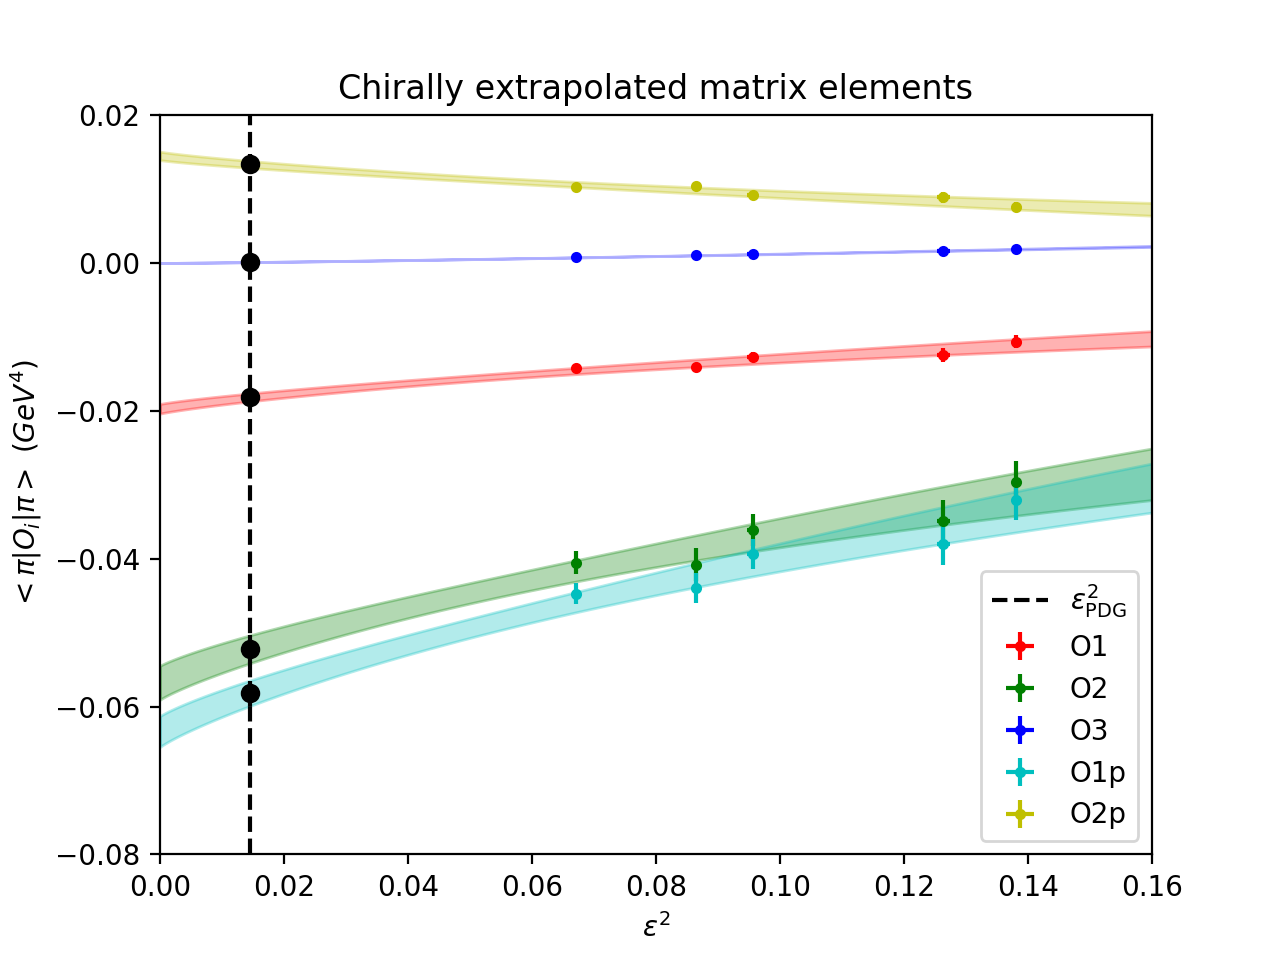

In [14]:
epsilon_sq_range = m_range ** 2 / (8 * (np.pi ** 2) * (fpi_0_ens.avg) ** 2)
eps_sq_0 = mpi_0[0] ** 2 / (8 * (np.pi ** 2) * (fpi_0[0] ** 2))
eps_sq_subtracted = [Superboot(n_ens) for i in range(n_ens)]
for i in range(n_ens):
    for ens_idx in range(n_ens):
        for b_idx in range(n_boot):
            eps_sq_subtracted[i].boots[ens_idx, b_idx] = mpi_ens[i].boots[ens_idx, b_idx] ** 2 / (8 * (np.pi**2) \
                                                            * (fpi_0_ens.boots[ens_idx, b_idx] ** 2))
eps_sq_sub_mu = [eps_sq_subtracted[i].compute_mean() for i in range(n_ens)]    # may want to make .avg instead
eps_sq_sub_sigma = [eps_sq_subtracted[i].compute_std() for i in range(n_ens)]
# get data points
mat_elems_sub_mu = [[mat_elems_subtracted[i][j].compute_mean() for i in range(n_ens)] for j in range(n_ops)]
mat_elems_sub_sigma = [[mat_elems_subtracted[i][j].compute_std() for i in range(n_ens)] for j in range(n_ops)]
# get band
# band_data_mu = [[band_data[i][j].compute_mean() for j in range(n_ops)] for i in range(len(m_range) - 1)]
# band_data_sigma = [[band_data[i][j].compute_std() for j in range(n_ops)] for i in range(len(m_range) - 1)]
band_data_mu = np.array([[band_data[i][j].compute_mean() for i in range(len(m_range) - 1)] for j in range(n_ops)])
band_data_sigma = np.array([[band_data[i][j].compute_std() for i in range(len(m_range) - 1)] for j in range(n_ops)])

plt.figure()
for j in range(n_ops):
    plt.errorbar(eps_sq_sub_mu, mat_elems_sub_mu[j], xerr = eps_sq_sub_sigma, yerr = mat_elems_sub_sigma[j], \
                 c = colors[j], fmt = '.', label = labels[j])
    plt.fill_between(epsilon_sq_range[1:], band_data_mu[j] + band_data_sigma[j], band_data_mu[j] - band_data_sigma[j], \
                    color = colors[j], alpha = 0.3)
plt.vlines(eps_sq_0, -0.08, 0.02, linestyles = 'dashed', label = '$\epsilon^2_{\mathrm{PDG}}$')
plt.errorbar([eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0], O_phys_mu, yerr = O_phys_sigma, c = 'k', fmt = 'o')
plt.legend(loc = 'lower right')
plt.xlim((0.0, 0.16))
plt.ylim((-0.08, 0.02))
plt.title('Chirally extrapolated matrix elements')
plt.xlabel('$\epsilon^2$')
# for some reason matplotlib breaks when we use \rangle in latex?
plt.ylabel('$<\pi|O_i|\pi>$ $(GeV^4)$')
plt.show()

In [15]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/plots/chiral_extrap/my_data.pdf')

## Notes

RESULTS FOR FITS TO THE MEAN

I generated fake data based on David's results for mpi and fpi and put them through the function which fits to their means-- it got pretty close to the values that his actual code spits out, when the L value was set to 32 each time. When I corrected the code it was still pretty close to what he had. Here's what David's code spits out:
O1
[-1.3102490330637617, -1.7066608393579843, -0.8422449312953697]
O2
[10.175257387129525, -4.966574781162899, -1.1703248819465772]
O3
[51.5038664286794, 0.6004464229091153, 1.7476029824455277]
O1p
[-1.5315739501273549, -5.489990421744237, -1.0860719237531953]
O2p
[7.343578513224973, 1.2660260632687053, -1.1274407384203236]

Here are the results from my code, using David's numbers to generate fake data, with L = 32 everywhere:
O1
[-1.20250871 -1.699562   -0.85025151]
O2
[10.24026743 -4.94628411 -1.17843114]
O3
[51.17464927  0.60353138  1.60246262]
O1p
[-1.44404244 -5.47414468 -1.10505762]
O2p
[ 7.44079538  1.26197142 -1.11098124]

And here are the results of my code, using David's numbers to generate fake data, with the correct value of L
O1
[-1.47760682 -1.6985531  -0.81686195]
O2
[ 9.98126654 -4.94366356 -1.14693482]
O3
[51.47078419  0.60335902  1.58085964]
O1p
[-1.71935554 -5.47075782 -1.07157295]
O2p
[ 7.17470892  1.26197194 -1.08468667]


Finally, if I use my data (with the correct value of L), I get a very different result. This is likely due to the fact that my fpi fits seem to give pretty different results-- need to check these and see what's going on. In the raw data, notice how the epsilon^2 values seem to be pretty different.
O1
[-7.16650898 -1.72766092 -0.17137882]
O2
[ 3.19326516 -4.9742111  -0.27528603]
O3
[43.60165803  0.63308699  1.39549587]
O1p
[-7.2709804  -5.5523971  -0.41884921]
O2p
[ 0.65288339  1.27018767 -0.2876572 ]

RESULTS FOR FITS TO THE FULL DATA WITH STATISTICS
David's numbers are in the notes he gave me. For the fake data, I generated fake ensembles with his numbers. I've saved plots from the chiral extrapolation in the folder research/0nubb/short_distance/chiral_extrap.

Results from my code using David's numbers to generate fake data, with L = 32 in f1: The plot for this is called 'david_data_buggy_code.pdf'. 
Fit parameters for operator O1
alpha = -1.1952923105750501 \pm 2.4232318685016687
beta = -1.6994125525843942 \pm 0.06894923313114809
c = -0.8478857721620399 \pm 0.42561839796501455
Fit parameters for operator O2
alpha = 10.25607199144804 \pm 3.237465976998419
beta = -4.945760266098866 \pm 0.25418046037910413
c = -1.1746486380349297 \pm 0.5360807050000578
Fit parameters for operator O3
alpha = 51.18682468116901 \pm 2.5406990329994716
beta = 0.6034953545922799 \pm 0.014862089003006899
c = 1.605380169186574 \pm 0.5921588562456657
Fit parameters for operator O1p
alpha = -1.437061479029064 \pm 2.36737668643327
beta = -5.4736652066393034 \pm 0.2175374717957628
c = -1.102885781343092 \pm 0.40934025689340536
Fit parameters for operator O2p
alpha = 7.442395660837931 \pm 0.6403661895226712
beta = 1.2619134184055125 \pm 0.014275051766372084
c = -1.1107447831821937 \pm 0.12393024098384445
Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.017695036164755037 \pm 0.00067868856980416
<pi|O2|pi> = -0.05122880377975424 \pm 0.002460141490902251
<pi|O3|pi> = 0.00011926473572161716 \pm 2.338028050502914e-06
<pi|O1p|pi> = -0.056763155854780624 \pm 0.0021450279659343215
<pi|O2p|pi> = 0.013084976490316787 \pm 0.00016967111307890042

Results from my code using David's numbers to generate fake data, with correct value of L in f1:
Fit parameters for operator O1
alpha = -1.4703869550032955 \pm 2.4232374162785835
beta = -1.6984031457401352 \pm 0.06880340920983277
c = -0.8144999249531516 \pm 0.4253689279117576
Fit parameters for operator O2
alpha = 9.997066827141868 \pm 3.2378708235836617
beta = -4.94313880822723 \pm 0.2537642907579481
c = -1.1431567921190475 \pm 0.5359239169173328
Fit parameters for operator O3
alpha = 51.48298021930898 \pm 2.543668509271114
beta = 0.6033305797019024 \pm 0.014884661038272625
c = 1.583327493709689 \pm 0.5932071339905192
Fit parameters for operator O1p
alpha = -1.7123706627798156 \pm 2.3674259990976902
beta = -5.470277244756541 \pm 0.21706558466921363
c = -1.0694054158129125 \pm 0.40910386276330585
Fit parameters for operator O2p
alpha = 7.176317790506278 \pm 0.6397362804138845
beta = 1.2619136971513203 \pm 0.014200927008520178
c = -1.0844519824046788 \pm 0.1236139068843035
Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.017693920897671796 \pm 0.0006777561883768293
<pi|O2|pi> = -0.05122744422013253 \pm 0.0024576851975487896
<pi|O3|pi> = 0.00011920018637870915 \pm 2.340104008053997e-06
<pi|O1p|pi> = -0.05675836741349343 \pm 0.0021419892665343818
<pi|O2p|pi> = 0.013090476037653698 \pm 0.00016916232505704334

Results from my code using my data, with correct value of L in f1:
Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.01817977862601922 \pm 0.000537991979223405
<pi|O2|pi> = -0.052255283438707084 \pm 0.0018902251284648097
<pi|O3|pi> = 0.00012479699318107833 \pm 2.5914655655857415e-06
<pi|O1p|pi> = -0.058198972660061216 \pm 0.001722408726239742
<pi|O2p|pi> = 0.01334112508669661 \pm 0.0004690395619702873

Tests with David's data: Run the full analysis by taking David's data points in the document (note that he has saved data for this, but it's jackknifed, so instead I'll just generate fake bootstrapped ensembles) with both the buggy code (the one in David's script with the wrong value of L in f1) and the corrected code. Compare to David's values for the chiral extrapolation. Also note that even with using David's data, since I'm generating a different ensemble from his data it shouldn't match exactly, but it (especially the buggy output) should match his results up to uncertainty.